### Creating a word embedding from scratch

In [5]:
import re
import numpy as np

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]    

In [6]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

In [9]:
# Reading the text from the input folder
texts = pd.read_csv('data/sample.csv')
texts = [x for x in texts['text']]

# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

In [10]:
for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

In [11]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

In [12]:
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

84it [00:00, 51343.86it/s]


In [13]:
# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

# Defining the size of the embedding
embed_size = 2

In [14]:
# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )


Epoch 1/1000
84/84 [==============================] - 0s 1ms/step - loss: 3.0810
Epoch 2/1000
84/84 [==============================] - 0s 18us/step - loss: 3.0798
Epoch 3/1000
84/84 [==============================] - 0s 19us/step - loss: 3.0786
Epoch 4/1000
84/84 [==============================] - 0s 18us/step - loss: 3.0774
Epoch 5/1000
84/84 [==============================] - 0s 19us/step - loss: 3.0762
Epoch 6/1000
84/84 [==============================] - 0s 16us/step - loss: 3.0750
Epoch 7/1000
84/84 [==============================] - 0s 27us/step - loss: 3.0738
Epoch 8/1000
84/84 [==============================] - 0s 20us/step - loss: 3.0727
Epoch 9/1000
84/84 [==============================] - 0s 20us/step - loss: 3.0715
Epoch 10/1000
84/84 [==============================] - 0s 20us/step - loss: 3.0703
Epoch 11/1000
84/84 [==============================] - 0s 19us/step - loss: 3.0692
Epoch 12/1000
84/84 [==============================] - 0s 18us/step - loss: 3.0680
Epoch 13/1000

Epoch 98/1000
84/84 [==============================] - 0s 34us/step - loss: 2.9810
Epoch 99/1000
84/84 [==============================] - 0s 27us/step - loss: 2.9801
Epoch 100/1000
84/84 [==============================] - 0s 24us/step - loss: 2.9791
Epoch 101/1000
84/84 [==============================] - 0s 24us/step - loss: 2.9782
Epoch 102/1000
84/84 [==============================] - 0s 21us/step - loss: 2.9773
Epoch 103/1000
84/84 [==============================] - 0s 25us/step - loss: 2.9763
Epoch 104/1000
84/84 [==============================] - 0s 22us/step - loss: 2.9754
Epoch 105/1000
84/84 [==============================] - 0s 21us/step - loss: 2.9745
Epoch 106/1000
84/84 [==============================] - 0s 20us/step - loss: 2.9735
Epoch 107/1000
84/84 [==============================] - 0s 20us/step - loss: 2.9726
Epoch 108/1000
84/84 [==============================] - 0s 19us/step - loss: 2.9717
Epoch 109/1000
84/84 [==============================] - 0s 22us/step - loss: 2

Epoch 196/1000
84/84 [==============================] - 0s 17us/step - loss: 2.8891
Epoch 197/1000
84/84 [==============================] - 0s 20us/step - loss: 2.8881
Epoch 198/1000
84/84 [==============================] - 0s 26us/step - loss: 2.8872
Epoch 199/1000
84/84 [==============================] - 0s 21us/step - loss: 2.8862
Epoch 200/1000
84/84 [==============================] - 0s 19us/step - loss: 2.8852
Epoch 201/1000
84/84 [==============================] - 0s 17us/step - loss: 2.8843
Epoch 202/1000
84/84 [==============================] - 0s 18us/step - loss: 2.8833
Epoch 203/1000
84/84 [==============================] - 0s 18us/step - loss: 2.8824
Epoch 204/1000
84/84 [==============================] - 0s 21us/step - loss: 2.8814
Epoch 205/1000
84/84 [==============================] - 0s 23us/step - loss: 2.8805
Epoch 206/1000
84/84 [==============================] - 0s 17us/step - loss: 2.8795
Epoch 207/1000
84/84 [==============================] - 0s 18us/step - loss:

Epoch 294/1000
84/84 [==============================] - 0s 18us/step - loss: 2.7958
Epoch 295/1000
84/84 [==============================] - 0s 19us/step - loss: 2.7949
Epoch 296/1000
84/84 [==============================] - 0s 20us/step - loss: 2.7939
Epoch 297/1000
84/84 [==============================] - 0s 20us/step - loss: 2.7930
Epoch 298/1000
84/84 [==============================] - 0s 18us/step - loss: 2.7921
Epoch 299/1000
84/84 [==============================] - 0s 22us/step - loss: 2.7911
Epoch 300/1000
84/84 [==============================] - 0s 21us/step - loss: 2.7902
Epoch 301/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7893
Epoch 302/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7884
Epoch 303/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7875
Epoch 304/1000
84/84 [==============================] - 0s 17us/step - loss: 2.7865
Epoch 305/1000
84/84 [==============================] - 0s 17us/step - loss:

Epoch 392/1000
84/84 [==============================] - 0s 17us/step - loss: 2.7098
Epoch 393/1000
84/84 [==============================] - 0s 19us/step - loss: 2.7090
Epoch 394/1000
84/84 [==============================] - 0s 38us/step - loss: 2.7082
Epoch 395/1000
84/84 [==============================] - 0s 22us/step - loss: 2.7074
Epoch 396/1000
84/84 [==============================] - 0s 24us/step - loss: 2.7066
Epoch 397/1000
84/84 [==============================] - 0s 18us/step - loss: 2.7057
Epoch 398/1000
84/84 [==============================] - 0s 21us/step - loss: 2.7049
Epoch 399/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7041
Epoch 400/1000
84/84 [==============================] - 0s 15us/step - loss: 2.7033
Epoch 401/1000
84/84 [==============================] - 0s 18us/step - loss: 2.7025
Epoch 402/1000
84/84 [==============================] - 0s 20us/step - loss: 2.7017
Epoch 403/1000
84/84 [==============================] - 0s 27us/step - loss:

Epoch 490/1000
84/84 [==============================] - 0s 19us/step - loss: 2.6351
Epoch 491/1000
84/84 [==============================] - 0s 16us/step - loss: 2.6344
Epoch 492/1000
84/84 [==============================] - 0s 18us/step - loss: 2.6337
Epoch 493/1000
84/84 [==============================] - 0s 20us/step - loss: 2.6329
Epoch 494/1000
84/84 [==============================] - 0s 18us/step - loss: 2.6322
Epoch 495/1000
84/84 [==============================] - 0s 17us/step - loss: 2.6315
Epoch 496/1000
84/84 [==============================] - 0s 16us/step - loss: 2.6308
Epoch 497/1000
84/84 [==============================] - 0s 17us/step - loss: 2.6301
Epoch 498/1000
84/84 [==============================] - 0s 19us/step - loss: 2.6294
Epoch 499/1000
84/84 [==============================] - 0s 36us/step - loss: 2.6287
Epoch 500/1000
84/84 [==============================] - 0s 26us/step - loss: 2.6280
Epoch 501/1000
84/84 [==============================] - 0s 22us/step - loss:

Epoch 588/1000
84/84 [==============================] - 0s 17us/step - loss: 2.5688
Epoch 589/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5681
Epoch 590/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5675
Epoch 591/1000
84/84 [==============================] - 0s 17us/step - loss: 2.5668
Epoch 592/1000
84/84 [==============================] - 0s 20us/step - loss: 2.5662
Epoch 593/1000
84/84 [==============================] - 0s 17us/step - loss: 2.5656
Epoch 594/1000
84/84 [==============================] - 0s 16us/step - loss: 2.5649
Epoch 595/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5643
Epoch 596/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5636
Epoch 597/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5630
Epoch 598/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5624
Epoch 599/1000
84/84 [==============================] - 0s 15us/step - loss:

Epoch 686/1000
84/84 [==============================] - 0s 16us/step - loss: 2.5082
Epoch 687/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5076
Epoch 688/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5070
Epoch 689/1000
84/84 [==============================] - 0s 16us/step - loss: 2.5064
Epoch 690/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5058
Epoch 691/1000
84/84 [==============================] - 0s 19us/step - loss: 2.5052
Epoch 692/1000
84/84 [==============================] - 0s 20us/step - loss: 2.5046
Epoch 693/1000
84/84 [==============================] - 0s 16us/step - loss: 2.5040
Epoch 694/1000
84/84 [==============================] - 0s 17us/step - loss: 2.5034
Epoch 695/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5028
Epoch 696/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5022
Epoch 697/1000
84/84 [==============================] - 0s 16us/step - loss:

Epoch 784/1000
84/84 [==============================] - 0s 19us/step - loss: 2.4514
Epoch 785/1000
84/84 [==============================] - 0s 19us/step - loss: 2.4508
Epoch 786/1000
84/84 [==============================] - 0s 18us/step - loss: 2.4502
Epoch 787/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4497
Epoch 788/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4491
Epoch 789/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4485
Epoch 790/1000
84/84 [==============================] - 0s 17us/step - loss: 2.4480
Epoch 791/1000
84/84 [==============================] - 0s 20us/step - loss: 2.4474
Epoch 792/1000
84/84 [==============================] - 0s 28us/step - loss: 2.4469
Epoch 793/1000
84/84 [==============================] - 0s 23us/step - loss: 2.4463
Epoch 794/1000
84/84 [==============================] - 0s 20us/step - loss: 2.4457
Epoch 795/1000
84/84 [==============================] - 0s 16us/step - loss:

Epoch 882/1000
84/84 [==============================] - 0s 17us/step - loss: 2.3980
Epoch 883/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3975
Epoch 884/1000
84/84 [==============================] - 0s 17us/step - loss: 2.3970
Epoch 885/1000
84/84 [==============================] - 0s 17us/step - loss: 2.3964
Epoch 886/1000
84/84 [==============================] - 0s 17us/step - loss: 2.3959
Epoch 887/1000
84/84 [==============================] - 0s 16us/step - loss: 2.3954
Epoch 888/1000
84/84 [==============================] - 0s 20us/step - loss: 2.3949
Epoch 889/1000
84/84 [==============================] - 0s 19us/step - loss: 2.3944
Epoch 890/1000
84/84 [==============================] - 0s 22us/step - loss: 2.3939
Epoch 891/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3933
Epoch 892/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3928
Epoch 893/1000
84/84 [==============================] - 0s 17us/step - loss:

Epoch 980/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3503
Epoch 981/1000
84/84 [==============================] - 0s 19us/step - loss: 2.3499
Epoch 982/1000
84/84 [==============================] - 0s 21us/step - loss: 2.3494
Epoch 983/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3490
Epoch 984/1000
84/84 [==============================] - 0s 19us/step - loss: 2.3485
Epoch 985/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3481
Epoch 986/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3477
Epoch 987/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3472
Epoch 988/1000
84/84 [==============================] - 0s 17us/step - loss: 2.3468
Epoch 989/1000
84/84 [==============================] - 0s 18us/step - loss: 2.3463
Epoch 990/1000
84/84 [==============================] - 0s 22us/step - loss: 2.3459
Epoch 991/1000
84/84 [==============================] - 0s 17us/step - loss:

In [15]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })


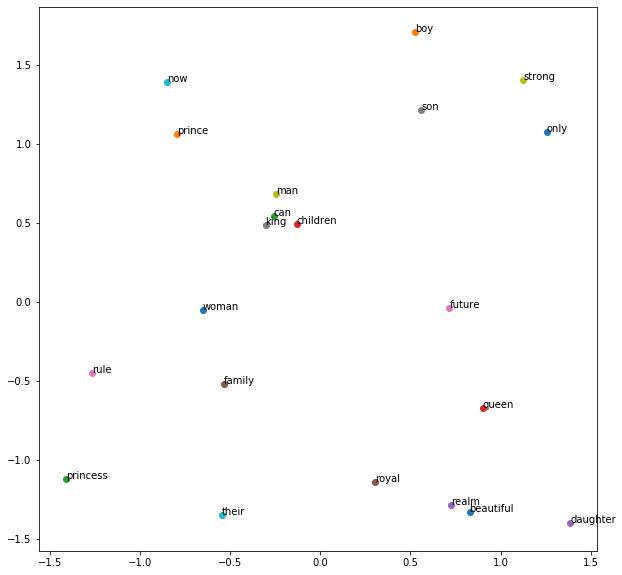

In [16]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

In [18]:
# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\output\\embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}') 